In [1]:
%pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
train = '1x_D1Feh88EFHQ63SEe55sAymUnztqzeK'
val = '1CcvUQxEuzPbwLOYjA1rxmyBxMF_au6wZ'
test = '1Kqf7-0Jkp1doGJWyhgxW1ku738IO4xji'

train_embeddings_per_word = '1kc018iaKNu8Y1DJd4WfyxWOxTQNNYt-h'
val_embeddings_per_word = '1--fg57qeqXEFrLqYvoVcN_9-o-Pzc26I'
test_embeddings_per_word = '1--K6JKVyn8UE9oo-4wzf5B6IzJ0JrI7c'

train_embeddings_per_sentence = '1-5dkTRFtcYbJJf5AWufBxgMba8FRSN7i'
val_embeddings_per_sentence = '1-FwXE-za1j3cBk9Cvw5T3DnzkJAGiY-M'
test_embeddings_per_sentence = '1-8icZrYP0oNUTnh6mwSGwK9fLAS1gcQU'

uncleaned_train_embedding = '13UONDopwe65QnuMK6jJWQUIdyx3OI-FA'
uncleaned_val_embedding = '1-0eCfZ8xSvLAI4RuC2e1WLf_Z09GmAaN'
uncleaned_test_embedding = '1-0CfuTbiTOIfDr4R76MO4Hd7GVeFlSrn'

cleaned_train_embedding = '1-1edBFG0soZn7J53Eow61r2MMjy09cy0'
cleaned_val_embedding = '1-3AHPvA5PH3VqKLqbUJHCMwPSS0R-dzw'
cleaned_test_embedding = '1fesPSynQmiGDwo0XXZ5ThLnuEYnS9-mG'

model_path = '1V9PmKPW7kLwpHGNk6xhEKlB2QWQ3BTNG'

In [3]:
!gdown {train}
!gdown {val}
!gdown {test}

!gdown {cleaned_train_embedding}
!gdown {cleaned_val_embedding}
!gdown {cleaned_test_embedding}

!gdown {model_path}

Downloading...
From: https://drive.google.com/uc?id=1x_D1Feh88EFHQ63SEe55sAymUnztqzeK
To: /kaggle/working/train.pkl
100%|███████████████████████████████████████| 3.59M/3.59M [00:00<00:00, 105MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CcvUQxEuzPbwLOYjA1rxmyBxMF_au6wZ
To: /kaggle/working/val.pkl
100%|████████████████████████████████████████| 769k/769k [00:00<00:00, 98.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Kqf7-0Jkp1doGJWyhgxW1ku738IO4xji
To: /kaggle/working/test.pkl
100%|█████████████████████████████████████████| 762k/762k [00:00<00:00, 125MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1-1edBFG0soZn7J53Eow61r2MMjy09cy0
From (redirected): https://drive.google.com/uc?id=1-1edBFG0soZn7J53Eow61r2MMjy09cy0&confirm=t&uuid=1c585786-0153-4b45-ad2c-ae5c9d3381a0
To: /kaggle/working/ls_train_embeddings.pkl
100%|███████████████████████████████████████| 2.16G/2.16G [00:17<00:00, 124MB/s]
Downloading...
From (uriginal): https://drive.google.c

In [4]:
import pandas as pd
import numpy as np
import pickle
import torch
import shap
import seaborn as sns
import tensorflow as tf
import keras
import keras_tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
from transformers import BertModel, AutoTokenizer, TFAutoModel

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/o

## Classes

In [5]:
label_to_class = {
    0: 'none',
    1: 'anger',
    2: 'joy',
    3: 'sadness',
    4: 'love',
    5: 'sympathy',
    6: 'surprise',
    7: 'fear'
}
classes = ['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear']

## Loading data

In [6]:
with open('/kaggle/working/train.pkl', 'rb') as f:
    train = pickle.load(f)
    
with open('/kaggle/working/val.pkl', 'rb') as f:
    val = pickle.load(f)

with open('/kaggle/working/test.pkl', 'rb') as f:
    test = pickle.load(f)

with open('/kaggle/working/train_embeddings_per_word.pkl', 'rb') as f:
    train_embeddings = pickle.load(f)
    
with open('/kaggle/working/val_embeddings_per_word.pkl', 'rb') as f:
    val_embeddings = pickle.load(f)
    
with open('/kaggle/working/test_embeddings_per_word.pkl', 'rb') as f:
    test_embeddings = pickle.load(f)

In [7]:
X_train = train['tweet']
y_train = train['label']
X_val = val['tweet']
y_val = val['label']
X_test = test['tweet']
y_test = test['label']

In [8]:
encoder = OneHotEncoder()

y_train = encoder.fit_transform(train['label'].values.reshape(-1,1)).toarray()
y_val = encoder.transform(val['label'].values.reshape(-1,1)).toarray()
y_test = encoder.transform(test['label'].values.reshape(-1,1)).toarray()

## Tokenizing and padding

In [ ]:
def prepare_tokenization(train, val, test=None, pad=500):
    global tokenizer
    tokenizer = Tokenizer(oov_token='<UNK>')
    tokenizer.fit_on_texts(train)
    tokenizer.word_index['<PAD>'] = 0
    train = tokenizer.texts_to_sequences(train)
    val = tokenizer.texts_to_sequences(val)
    if not pad==False:
        train = sequence.pad_sequences(train, maxlen=pad)
        val = sequence.pad_sequences(val, maxlen=pad)
    if not type(test)==type(None):
        test = tokenizer.texts_to_sequences(test)
        if not pad==False:
            test = sequence.pad_sequences(test, maxlen=pad)
    v_size = len(tokenizer.word_index)
    print("Vocabulary size={}".format(v_size))
    print("Number of Documents={}".format(tokenizer.document_count))
    if not type(test)==type(None):
        return v_size, train, val, test
    else:
        return v_size, train, val

In [ ]:
VOCAB_SIZE, train_sequences, val_sequences, test_sequences = prepare_tokenization(X_train, X_val, X_test, pad=True)

In [ ]:
model = BertModel.from_pretrained("UBC-NLP/MARBERT")
embedding_matrix = model.embeddings.word_embeddings.weight
VOCAB_SIZE_MARBERT = embedding_matrix.shape[0]

In [9]:
max_length = 50

In [10]:
X_train = train_embeddings
X_val = val_embeddings
X_test = test_embeddings

In [14]:
BATCH_SIZE = 64
EPOCHS = 50
EMBED_SIZE = 86#768#86
LEARNING_RATE =  0.002967008268835806

early_stopping_monitor = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True)

In [15]:
def build_gru(embedding_layer=False):
    model = Sequential()
    if embedding_layer:
        model.add(Embedding(VOCAB_SIZE_MARBERT, EMBED_SIZE, input_length=max_length, trainable=True))#, weights=[embedding_matrix.detach().numpy()]))
        model.add(GRU(128, return_sequences=True))
    else:
        model.add(GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(Dropout(0.011691195516528197))
    model.add(Dropout(0.42090879788545155))
    
    model.add(GRU(64, return_sequences=True))
    model.add(Dropout(0.42090879788545155))
    
    model.add(GRU(32, return_sequences=False))
    model.add(Dropout(0.42090879788545155))
    
    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer=Adam(LEARNING_RATE),
                loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [16]:
model = build_gru(embedding_layer=False)

history = model.fit(X_train, np.asarray(y_train), validation_data=(X_val, np.asarray(y_val)), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping_monitor])

Epoch 1/50
111/111 [==============================] - 14s 39ms/step - loss: 1.6543 - accuracy: 0.4058 - val_loss: 1.0948 - val_accuracy: 0.6404
Epoch 2/50
111/111 [==============================] - 2s 18ms/step - loss: 1.1007 - accuracy: 0.6288 - val_loss: 1.0175 - val_accuracy: 0.6517
Epoch 3/50
111/111 [==============================] - 2s 18ms/step - loss: 0.8706 - accuracy: 0.7175 - val_loss: 0.8366 - val_accuracy: 0.7212
Epoch 4/50
111/111 [==============================] - 2s 18ms/step - loss: 0.7590 - accuracy: 0.7571 - val_loss: 0.8739 - val_accuracy: 0.7245
Epoch 5/50
111/111 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.7776 - val_loss: 0.8883 - val_accuracy: 0.7358
Epoch 6/50
111/111 [==============================] - 2s 22ms/step - loss: 0.6480 - accuracy: 0.7928 - val_loss: 0.8817 - val_accuracy: 0.7020
Epoch 7/50
111/111 [==============================] - 2s 19ms/step - loss: 0.6221 - accuracy: 0.7983 - val_loss: 0.8058 - val_accuracy: 0.724

In [14]:
# model = keras.models.load_model("GRRU")
model = keras.models.load_model("/kaggle/working/GRRU")

In [17]:
predictions = model.predict(X_test)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=classes))

48/48 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

        none       0.71      0.86      0.78       229
       anger       0.77      0.66      0.71       200
         joy       0.63      0.64      0.64       205
     sadness       0.65      0.65      0.65       185
        love       0.80      0.73      0.76       193
    sympathy       0.84      0.93      0.88       156
    surprise       0.79      0.66      0.72       154
        fear       0.90      0.93      0.91       188

    accuracy                           0.76      1510
   macro avg       0.76      0.76      0.76      1510
weighted avg       0.76      0.76      0.75      1510



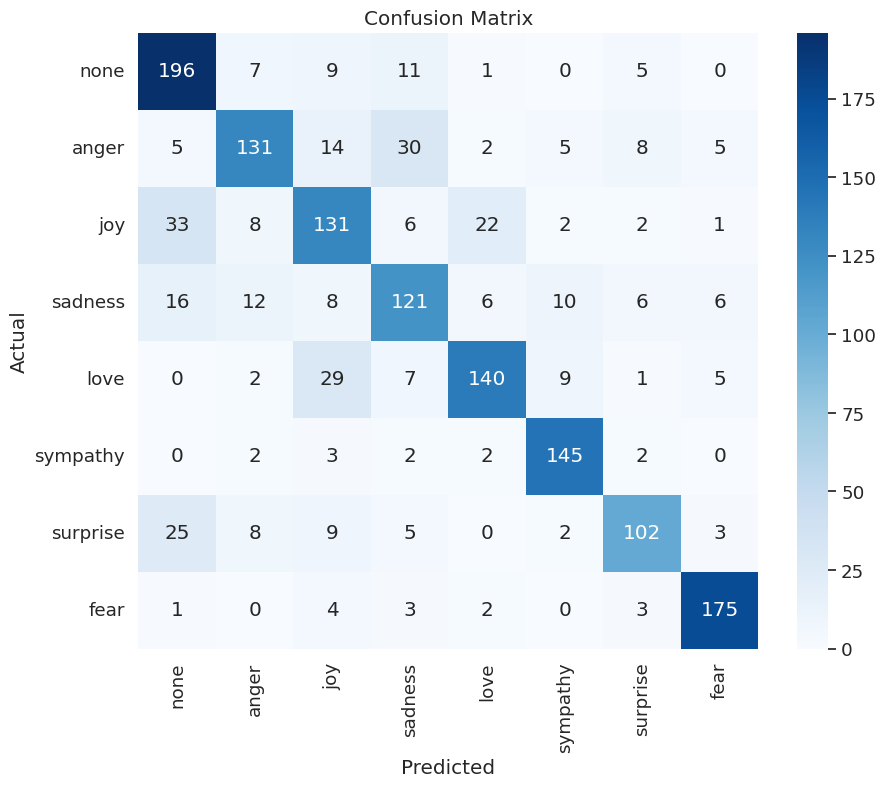

In [18]:
cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
model.save('GRRU')

In [20]:
!zip -r GRU.zip /kaggle/working/GRRU

updating: kaggle/working/GRRU/ (stored 0%)
updating: kaggle/working/GRRU/variables/ (stored 0%)
updating: kaggle/working/GRRU/variables/variables.index (deflated 64%)
updating: kaggle/working/GRRU/variables/variables.data-00000-of-00001 (deflated 6%)
updating: kaggle/working/GRRU/saved_model.pb (deflated 90%)
updating: kaggle/working/GRRU/assets/ (stored 0%)
updating: kaggle/working/GRRU/keras_metadata.pb (deflated 91%)
updating: kaggle/working/GRRU/fingerprint.pb (stored 0%)


In [21]:
def map_label_to_class(indices, classes):
  return [classes[idx] for idx in indices]

def create_csv(y_pred_idx, y_true_idx, file_path="examples.csv"):
  y_pred, y_true = map_label_to_class(y_pred_idx, label_to_class), map_label_to_class(y_true_idx, label_to_class)
  with open(file_path, 'w') as file:
    file.write('Index,True Label,Predicted Label\n')
    for i in range(len(y_pred)):
      file.write(f'{i},{y_true[i]},{y_pred[i]}\n')
  print("Content has been written to the file.")

In [23]:
create_csv(predictions.argmax(axis=1), y_test.argmax(axis=1), file_path="gru.csv")

Content has been written to the file.


In [24]:
misclassified = np.where(y_test.argmax(axis=1)!=predictions.argmax(axis=1))[0]
correctly_classified = np.where(y_test.argmax(axis=1)==predictions.argmax(axis=1))[0]

In [25]:
len(misclassified), len(correctly_classified), len(predictions)

(369, 1141, 1510)

In [26]:
problematic_samples = {'predicted':['none', 'none', 'joy', 'sadness', 'love', 'none'], 'actual':['joy', 'surprise', 'love', 'anger', 'joy', 'sadness']}
problematic_indices = []

In [28]:
for predicted, actual in zip(problematic_samples['predicted'], problematic_samples['actual']):
    tmp = []
    for idx, data in enumerate(zip(predictions.argmax(axis=1), y_test.argmax(axis=1))):
        pred, true = data
        if classes[pred]==predicted and classes[true]==actual:
            tmp.append(idx)
    problematic_indices.append(tmp)

In [29]:
sum([len(x) for x in problematic_indices])

155

### Predicted none, Actual joy

In [37]:
for pair_idx, indices in enumerate(problematic_indices):
    print()
    print()
    print('--------------------------------------------------------------------------')
    print('Predicted: ', problematic_samples['predicted'][pair_idx])
    print('Actual: ', problematic_samples['actual'][pair_idx])
    for idx in indices:
        print('Index: ', idx)
        print('Tweet: ', test['tweet'].values.tolist()[idx])
        print('Light stemming: ', test['Light Stemming'].values.tolist()[idx])
        print()



--------------------------------------------------------------------------
Predicted:  none
Actual:  joy
Index:  2
Tweet:  الاوليمبياد السنه دي افشخ من سيدني اللي كنا بنزوغ من المدرسه علشان نتفرج عليها 😀
Light stemming:  الاوليمبياد السنه افشخ سيد اللي كنا بنزوغ المدرسه نتفرج فرح

Index:  23
Tweet:  جايز جدا وممكن بالعوامه البطه في الاوليمبياد الجاي😂😂😂😂😂😂😂
Light stemming:  جايز ومم بالعوامه البطه الاوليمبياد الجاي فرح فرح فرح فرح فرح فرح فرح

Index:  45
Tweet:  اللعب في الاوليمبياد حلم اي لاعب و بالامكانيات اللي عندهم التاهل في حد ذاته انجاز معقول
Light stemming:  اللعب الاوليمبياد حلم اي لاعب بالامكاني اللي التاهل انجاز معقول

Index:  62
Tweet:  حسناً من الواضح اننا سنتابع الاوليمبياد . 🤔😄
Light stemming:  حسنا الواضح اننا سنتابع الاوليمبياد فرح

Index:  95
Tweet:  الاوليمبياد * : D
Light stemming:  الاوليمبياد

Index:  129
Tweet:  المتابعه القريبه من وسائل اعلام كتيره لمشاركات المصريين في الاوليمبياد، مع صورهم اللي ماليه الشوارع من الحاجات الايجابيه المبهجه مؤخرا
Light stemming:  ا

## Explaining manually selected samples for each problematic block using LIME

In [ ]:
manually_selected_samples = []

## Prediced: none, Actual: joy

In [ ]:
manually_selected_samples.append([2,23,189,534,1402])

In [ ]:
for sample in manually_selected_samples[0]:
    lime_explain(sample)

## Prediced: none, Actual: surprise

In [ ]:
manually_selected_samples.append([154,1158,1014,848,811])

In [ ]:
for sample in manually_selected_samples[1]:
    lime_explain(sample)

## Prediced: joy, Actual: love

In [38]:
manually_selected_samples.append([298,320,932,985,276])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 manually_selected_samples.append([298,320,932,985,276])                                      │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'manually_selected_samples' is not defined

In [ ]:
for sample in manually_selected_samples[0]:
    lime_explain(sample)